In [4]:
from preprocessing.preprocess_ucr import UCRDatasetImporter
from preprocessing.data_pipeline import build_data_pipeline
from utils import load_yaml_param_settings

from utils import time_to_timefreq, timefreq_to_time

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

/home/erlendlokna/Documents/ntnu/Generative-SSL-VQVAE-modelling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config_dir = 'configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['stage1']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

self.X_train.shape: (500, 140)
self.X_test.shape: (4500, 140)
# unique labels (train): [0 1 2 3 4]
# unique labels (test): [0 1 2 3 4]


In [55]:
def add_random_masks(time_frequency_array, mask_density=0.2, **kwargs):
    """
    Add random zero masks to a time-frequency array.

    Parameters:
    - time_frequency_array (numpy.ndarray): The input time-frequency array.
    - mask_density (float): The density of the random zero masks. 
                            A value between 0 and 1, indicating the proportion of zeros to add.

    Returns:
    - masked_array (numpy.ndarray): The time-frequency array with random zero masks.
    """
    if not (0 <= mask_density <= 1):
        raise ValueError("mask_density should be between 0 and 1")

    masked_array = time_frequency_array.copy()

    # Determine the number of zeros to add based on the mask_density
    num_zeros = int(mask_density * time_frequency_array.size)

    # Generate random indices to set to zero
    mask_indices = np.random.choice(time_frequency_array.size, num_zeros, replace=False)

    # Set the selected indices to zero
    masked_array.ravel()[mask_indices] = 0

    return masked_array



def add_rotation_augmentation(time_frequency_array, rotation_max_angle, **kwargs):
    """
    Add random rotations to a time-frequency array.

    Parameters:
    - time_frequency_array (numpy.ndarray): The input time-frequency array.
    - max_angle (float): The maximum rotation angle in degrees.

    Returns:
    - rotated_array (numpy.ndarray): The time-frequency array with random rotations.
    """
    if rotation_max_angle < 0:
        raise ValueError("max_angle should be a non-negative value")

    # Generate a random rotation angle between -max_angle and max_angle
    rotation_angle = np.random.uniform(-rotation_max_angle, rotation_max_angle)

    # Perform the rotation using scipy's rotate function
    rotated_array = rotate(time_frequency_array, angle=rotation_angle, reshape=False)

    return rotated_array


def add_random_amplitude_scaling(time_frequency_array, min_scale=0.8, max_scale=1.2, **kwargs):
    """
    Add random amplitude scaling to a time-frequency array.

    Parameters:
    - time_frequency_array (numpy.ndarray): The input time-frequency array.
    - min_scale (float): The minimum scaling factor to apply.
    - max_scale (float): The maximum scaling factor to apply.

    Returns:
    - scaled_array (numpy.ndarray): The time-frequency array with random amplitude scaling.
    """
    if min_scale < 0 or max_scale < min_scale:
        raise ValueError("Invalid scaling factor values")

    # Generate a random scaling factor between min_scale and max_scale
    scaling_factor = np.random.uniform(min_scale, max_scale)


    # Apply the scaling factor to the magnitudes while keeping the phase information
    scaled_array = np.abs(time_frequency_array) * scaling_factor * np.exp(1j * np.angle(time_frequency_array))

    return scaled_array

def add_block_augmentation(u, block_size_scale=0.1, block_density=0.2, random_fill=False, **kwargs):
    if isinstance(u, torch.Tensor):
        u = u.numpy()  # Convert to NumPy array if input is a PyTorch tensor

    if block_density < 0 or block_density > 1:
        raise ValueError("Density should be between 0 and 1")

    if block_size_scale <= 0 or block_size_scale > 1:
        raise ValueError("Invalid scale factor")

    # Create a copy of the input array to apply augmentation
    augmented_array = u.copy()

    # Calculate the block size based on the scale factor and input dimensions
    block_height = int(augmented_array.shape[0] * block_size_scale)
    block_width = int(augmented_array.shape[1] * block_size_scale)

    # Determine the number of blocks to add
    num_blocks = int(block_density * (augmented_array.shape[0] * augmented_array.shape[1]))

    for _ in range(num_blocks):
        # Randomly choose a position for the block
        block_x = np.random.randint(0, augmented_array.shape[0] - block_height + 1)
        block_y = np.random.randint(0, augmented_array.shape[1] - block_width + 1)

        # Generate a random block with values (from a normal distribution) or zeros based on 'random_fill'
        if random_fill:
            block = np.random.randn(block_height, block_width)
        else:
            block = np.zeros((block_height, block_width))

        # Add the block to the time-frequency representation
        augmented_array[block_x:block_x + block_height, block_y:block_y + block_width] = block

    # Pad the augmented array to match the input size if needed
    pad_height = u.shape[0] - augmented_array.shape[0]
    pad_width = u.shape[1] - augmented_array.shape[1]
    if pad_height > 0 or pad_width > 0:
        augmented_array = np.pad(augmented_array, ((0, pad_height), (0, pad_width)), mode='constant')

    # Convert back to a PyTorch tensor if the input was a tensor
    if isinstance(u, torch.Tensor):
        augmented_array = torch.from_numpy(augmented_array)

    return augmented_array

def add_gaussian_augmentation(time_frequency_array, gaus_mean=0, gaus_std=0.01, **kwargs):
    """
    Add Gaussian noise to a time-frequency array.

    Parameters:
    - time_frequency_array (numpy.ndarray): The input time-frequency array.
    - mean (float): The mean of the Gaussian noise distribution.
    - std (float): The standard deviation of the Gaussian noise distribution.

    Returns:
    - noisy_array (numpy.ndarray): The time-frequency array with added Gaussian noise.
    """
    if gaus_std <= 0:
        raise ValueError("std (standard deviation) should be a positive value")

    # Generate Gaussian noise with the specified mean and standard deviation
    noise = np.random.normal(gaus_mean, gaus_std, time_frequency_array.shape)

    # Add the generated noise to the original time-frequency array
    noisy_array = time_frequency_array + noise

    return noisy_array

def add_band_augmentation(time_frequency_array, num_bands_to_remove=1, band_scale_factor=0.1, **kwargs):
    """
    Perform random scaled band augmentation on a time-frequency array by removing random frequency bands.

    Parameters:
    - time_frequency_array (numpy.ndarray): The input time-frequency array.
    - num_bands_to_remove (int): The number of frequency bands to randomly remove.
    - scale_factor (float): The scale factor for band width relative to the input representation.

    Returns:
    - augmented_array (numpy.ndarray): The time-frequency array with random scaled bands removed.
    """
    if num_bands_to_remove < 0 or num_bands_to_remove >= time_frequency_array.shape[0]:
        raise ValueError("Invalid number of bands to remove")

    if band_scale_factor <= 0 or band_scale_factor > 1:
        raise ValueError("Invalid scale factor")

    # Calculate the band width based on the scale factor and input representation height
    band_width = int(time_frequency_array.shape[0] * band_scale_factor)

    # Create a copy of the input array to apply augmentation
    augmented_view = time_frequency_array

    for _ in range(num_bands_to_remove):
        # Randomly choose a starting frequency for the band
        start_band = np.random.randint(0, time_frequency_array.shape[0] - band_width + 1)

        # Remove the selected band(s)
        augmented_view[start_band:start_band + band_width, :] = 0

    return augmented_view


def add_phase_augmentation(time_frequency_view, phase_max_change=np.pi/4, **kwargs):
    """
    Apply phase augmentation to a single time-frequency array view using PyTorch's STFT.

    Parameters:
    - time_frequency_view (numpy.ndarray): The input time-frequency array view.

    Returns:
    - augmented_view (numpy.ndarray): The time-frequency array view with complex phase augmentation.
    """
    n_channels, subseq_len = time_frequency_view.shape
    augmented_view = np.zeros((n_channels, subseq_len), dtype=np.complex64)

    for i in range(n_channels):
        time_frequency_tensor = torch.tensor(time_frequency_view[i], dtype=torch.float32)

        # Modify the phase of the time-frequency view while controlling phase changes
        phase = torch.angle(time_frequency_tensor)
        phase_change = torch.empty_like(phase).uniform_(-phase_max_change, phase_max_change)
        augmented_phase = phase + phase_change

        # Reconstruct the augmented time-frequency view with modified phase
        augmented_view[i] = torch.abs(time_frequency_tensor) * torch.exp(1j * augmented_phase)

    return augmented_view


In [78]:
def stft(x, n_fft, **kwargs):
    return torch.stft(torch.from_numpy(x), n_fft=n_fft, return_complex=True, onesided=False)

def istft(u, n_fft, original_length, **kwargs):
    istft_output = torch.istft(torch.from_numpy(u), n_fft=n_fft, return_complex=False, onesided=False)
    
    # Trim or zero-pad the ISTFT output to match the original length
    if len(istft_output) < original_length:
        pad_length = original_length - len(istft_output)
        istft_output = np.pad(istft_output, (0, pad_length))
    elif len(istft_output) > original_length:
        istft_output = istft_output[:original_length]
    
    return istft_output

def get_x_and_u(n_fft, **kwargs):
    X = torch.tensor(train_data_loader.dataset.X)
    i = np.random.randint(0, X.shape[0])
    
    return X[i], stft(X[i].numpy(), n_fft)

def plot(x, xaug, u, uaug):
    f, a = plt.subplots(1, 3, figsize=(15, 5))
    
    # Visualize the magnitude of the original and augmented STFT representations
    a[0].imshow(np.abs(u), aspect='auto', cmap='viridis')  # You can adjust the cmap
    a[1].imshow(np.abs(uaug), aspect='auto', cmap='viridis')  # You can adjust the cmap
    
    # Plot the original and augmented signals
    a[2].plot(x, label='original')
    a[2].plot(xaug, label='augmented')  # Include the augmented signal in the plot
    a[2].legend()
    
    plt.show()


def apply_timefreq_augmentations(x, aug_params):
    """
    Apply a random combination of augmentations to the input data.

    Parameters:
    - input_data: The input data to be augmented.
    - num_augmentations: The number of augmentations to apply (1 to 4).

    Returns:
    - augmented_data: The augmented data.
    - augmentation_combination: A list of the augmentation functions applied.
    """
    num_augmentations = aug_params['num_augmentations']
    n_fft = aug_params['n_fft']

    augmentations = [
        ('Rotation', add_rotation_augmentation),
        ('Band', add_band_augmentation),
        ('Block', add_block_augmentation),
        ('phase', add_phase_augmentation),
        #('jitter', add_gaussian_augmentation)
    ]

    # Shuffle the list of augmentations and select the first 'num_augmentations'
    np.random.shuffle(augmentations)
    selected_augmentations = augmentations[:num_augmentations]

    # Apply selected augmentations
    u = stft(x, n_fft)
    augmented_data = stft(x, n_fft)
    augmentation_combination = []

    for augmentation_name, augmentation_function in selected_augmentations:
        augmented_data = augmentation_function(augmented_data, **aug_params)
        augmentation_combination.append(augmentation_name)

    xaug = istft(augmented_data, n_fft, len(x))
    return xaug, augmentation_combination

In [79]:
aug_params = {
    "num_augmentations": 1,
    "n_fft": 16,
    "block_size_scale": 0.1,
    "block_density": 0.1,
    "num_bands_to_remove": 1,
    "band_scale_factor": 0.1,
    "gaus_mean": 0,
    "gaus_std": 0.01,
    "rotation_max_angle": 1,
}


# Random Block Augmentation


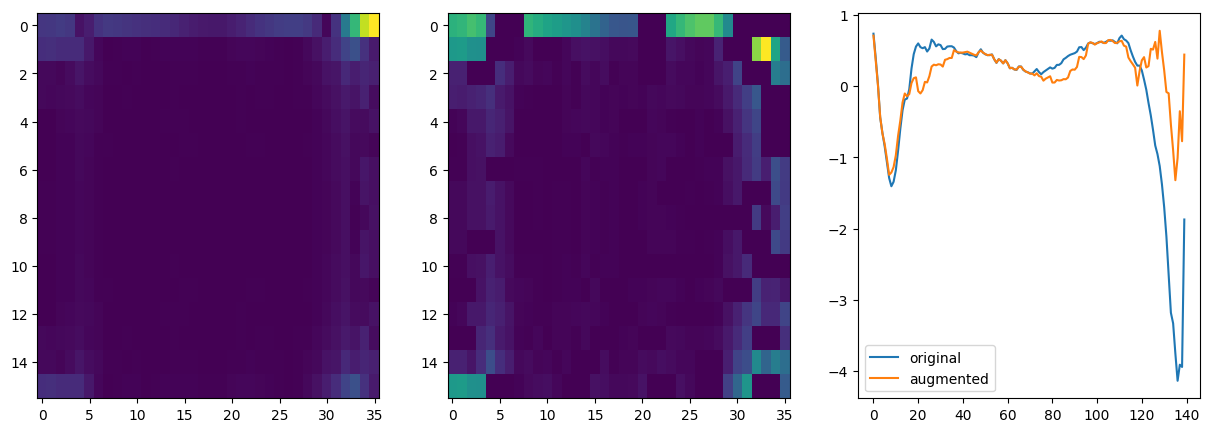

torch.Size([140]) torch.Size([140]) torch.Size([16, 36]) (16, 36)


In [68]:
x, u = get_x_and_u(**aug_params)

uaug_blocks = add_block_augmentation(u.numpy(), **augm_params)
xaug_block = istft(uaug_blocks, aug_params["n_fft"], x.shape[0])

plot(x, xaug_block, u, uaug_blocks)
print(x.shape, xaug_block.shape, u.shape, uaug_blocks.shape)

# Random band augmentation

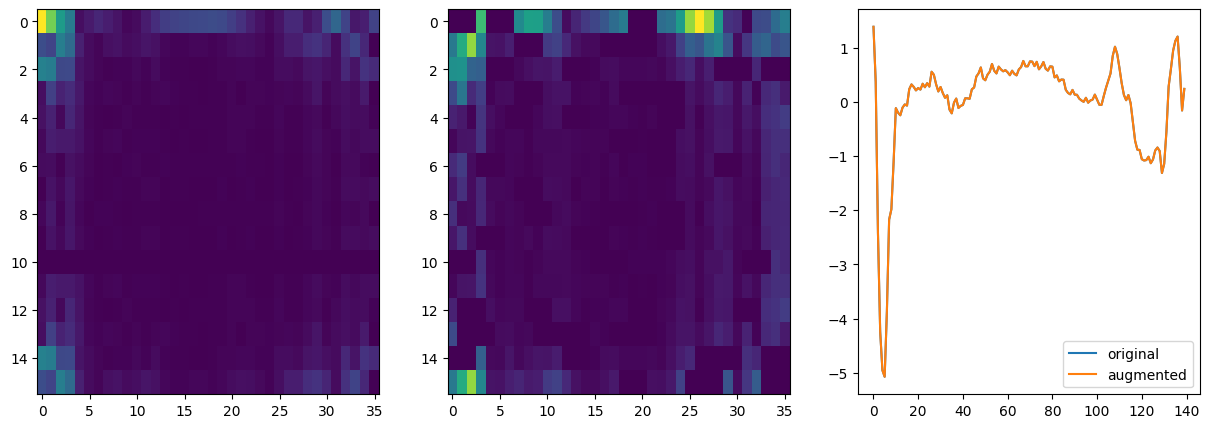

torch.Size([140]) torch.Size([140]) torch.Size([16, 36]) (16, 36)


In [56]:
x, u = get_x_and_u(**aug_params)


uaug_bands = add_band_augmentation(u.numpy(), **aug_params)
xaug_bands = istft(uaug_bands, aug_params["n_fft"], x.shape[0])

plot(x, xaug_bands, u, uaug_blocks)
print(x.shape, xaug_bands.shape, u.shape, uaug_bands.shape)

# Random Phase Augmentation

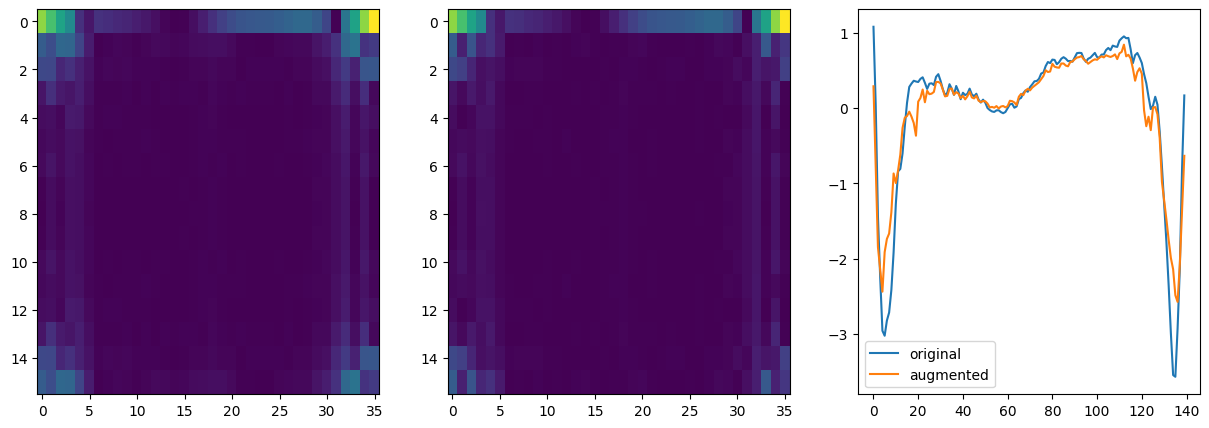

torch.Size([140]) torch.Size([140]) torch.Size([16, 36]) (16, 36)


In [57]:
x, u = get_x_and_u(**aug_params)

uaug_phase = add_phase_augmentation(u.numpy())
xaug_phase = istft(uaug_phase, aug_params['n_fft'], x.shape[0])

plot(x, xaug_phase, u, uaug_phase)
print(x.shape, xaug_phase.shape, u.shape, uaug_phase.shape)

# Random Rotation Augmentation

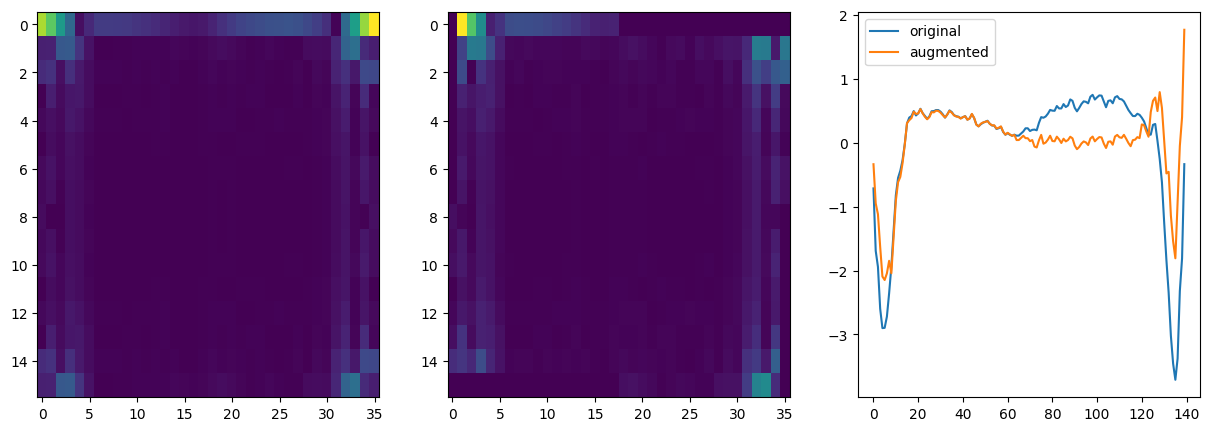

torch.Size([140]) torch.Size([140]) torch.Size([16, 36]) (16, 36)


In [62]:
x, u = get_x_and_u(**aug_params)

angle = 1

uaug_rot = add_rotation_augmentation(u.numpy(), **aug_params)
xaug_rot = istft(uaug_rot, aug_params['n_fft'], x.shape[0])

plot(x, xaug_rot, u, uaug_rot)
print(x.shape, xaug_rot.shape, u.shape, uaug_rot.shape)

# Gaussian augmentation


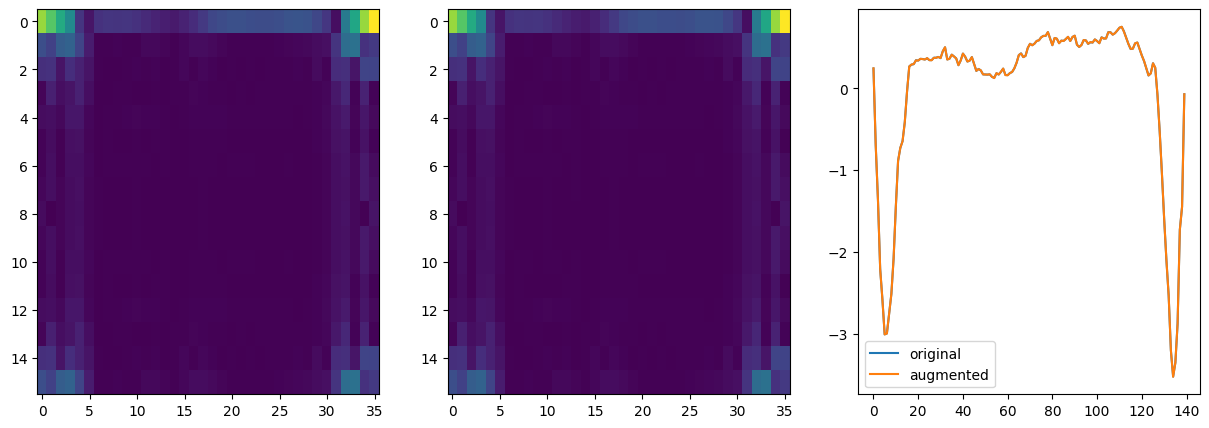

torch.Size([140]) torch.Size([140]) torch.Size([16, 36]) (16, 36)


In [65]:
x, u = get_x_and_u(**aug_params)

mean = 0
std = 0.5

uaug_gaus = add_gaussian_augmentation(u.numpy(), mean=mean, std=std)
xaug_gaus = istft(uaug_gaus, aug_params['n_fft'], x.shape[0])

plot(x, xaug_gaus, u, uaug_gaus)
print(x.shape, xaug_gaus.shape, u.shape, uaug_gaus.shape)

# Random choice augmentation

In [82]:
x, u = get_x_and_u(**aug_params)

xaug, augmentation_combination = apply_timefreq_augmentations(x.numpy(), aug_params=aug_params)

print("Augmentations:", augmentation_combination)

plt.plot(x)
plt.plot(xaug)


TypeError: apply_timefreq_augmentations() missing 1 required positional argument: 'n_fft'

In [513]:
x, u = get_x_and_u()

scale_factor = 0.1

m_bands = random_band_augmentation(u.numpy(), num_bands_to_remove=2, scale_factor=scale_factor)
m_blocks = add_block_augmentation(u.numpy(), scale=scale_factor, density=0.2, random_fill=False)
m_rotations = add_random_rotations(u.numpy(), max_angle=1)

xhat_band = torch.istft(torch.from_numpy(m_bands), n_fft=n_fft, return_complex=False)
xhat_block = torch.istft(torch.from_numpy(m_blocks), n_fft=n_fft, return_complex=False)
xhat_rot = torch.istft(torch.from_numpy(m_rotations), n_fft=n_fft, return_complex=False)

plt.plot(X[i], label='original')
plt.plot(xhat_block, label='Random band Augmentation')
plt.plot(xhat_band, label='Random block Augmentation')
plt.plot(xhat_rot, label='Random rotation')
plt.legend()

TypeError: get_x_and_u() missing 1 required positional argument: 'n_fft'

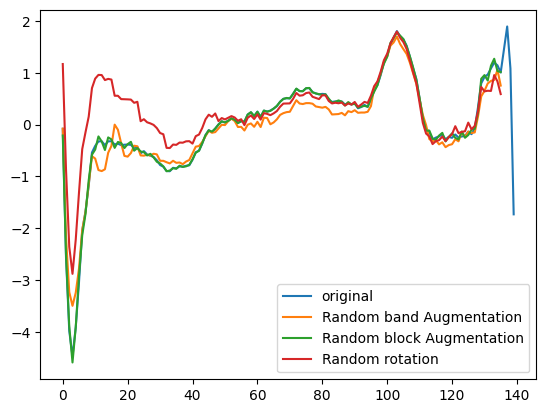

In [147]:
plt.plot(X[i], label='original')
plt.plot(xhat_block, label='Random band Augmentation')
plt.plot(xhat_band, label='Random block Augmentation')
plt.plot(xhat_rot, label='Random rotation')
plt.legend()

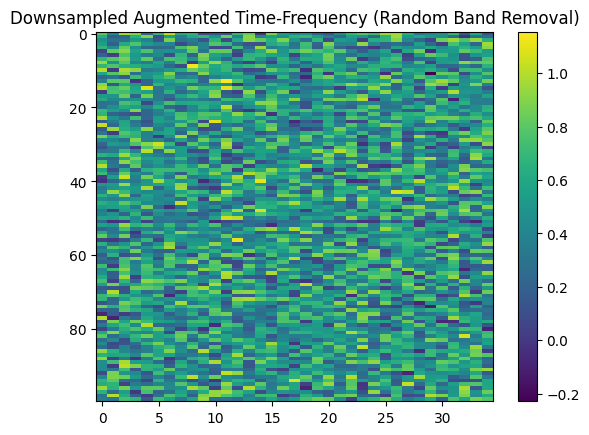

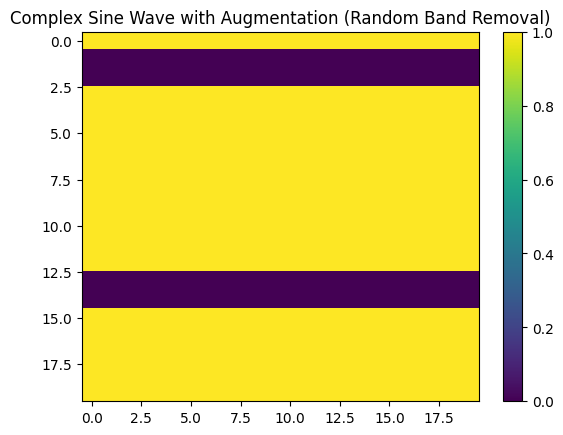

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Create a complex sine wave
fs = 1000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector from 0 to 1 second
frequency = 10  # Frequency of the sine wave (in Hz)
complex_sine_wave = np.exp(2j * np.pi * frequency * t)

# Reshape the complex sine wave into a time-frequency representation
time_frequency_array = np.abs(np.tile(complex_sine_wave, (400, 1)))
u = np.ones((20, 20))


# Add random band augmentation
augmented_time_frequency = random_band_augmentation(u, num_bands_to_remove=2)

# Visualize the augmented time-frequency representation
plt.imshow(augmented_time_frequency, cmap='viridis', aspect='auto')
plt.title('Complex Sine Wave with Augmentation (Random Band Removal)')
plt.colorbar()
plt.show()


In [358]:
blocks = add_block_augmentation(u, density=0.05, scale=0.1)
bands = add_band_augmentation(u, num_bands_to_remove=2, scale_factor=0.1)
jitter = add_random_rotations(u, max_angle=1)

f, a = plt.subplots(1, 3, figsize=(10, 5))
a[0].imshow(blocks, cmap='viridis', aspect='auto'); a[0].set_title('Random Block Augmentation')
a[1].imshow(bands, cmap='viridis', aspect='auto'); a[1].set_title('Band Augmentation')
a[2].imshow(jitter, cmap='viridis', aspect='auto'); a[2].set_title('Random Rotations')


AttributeError: 'Tensor' object has no attribute 'copy'

In [19]:
d = {"a": 1, "b": 2, "c": 3}
def f(a, b): return a + b
print(f(**d))


TypeError: f() got an unexpected keyword argument 'c'